<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo">
</center>


#### Import the required libraries we need for the lab.


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_openml

#### Read the dataset in the csv file from the URL


In [14]:

# Task 1: Load and explore the dataset
try:
    boston = fetch_openml(name='boston', as_frame=True, parser='auto').frame
    print("Successfully loaded Boston dataset from OpenML")
except Exception as e:
    print(f"Error loading from OpenML: {e}")
    print("Falling back to CSV version")
    boston = pd.read_csv(
        'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
    )

# Standardize column names to lowercase
boston.columns = [col.lower() for col in boston.columns]

Successfully loaded Boston dataset from OpenML


c:\Users\CompuMax\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


In [15]:
# Summary statistics
boston.describe()


,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


## Task 1: Generate Descriptive Statistics and Visualizations
This section includes boxplots, bar plots, scatter plots, and histograms with explanations.

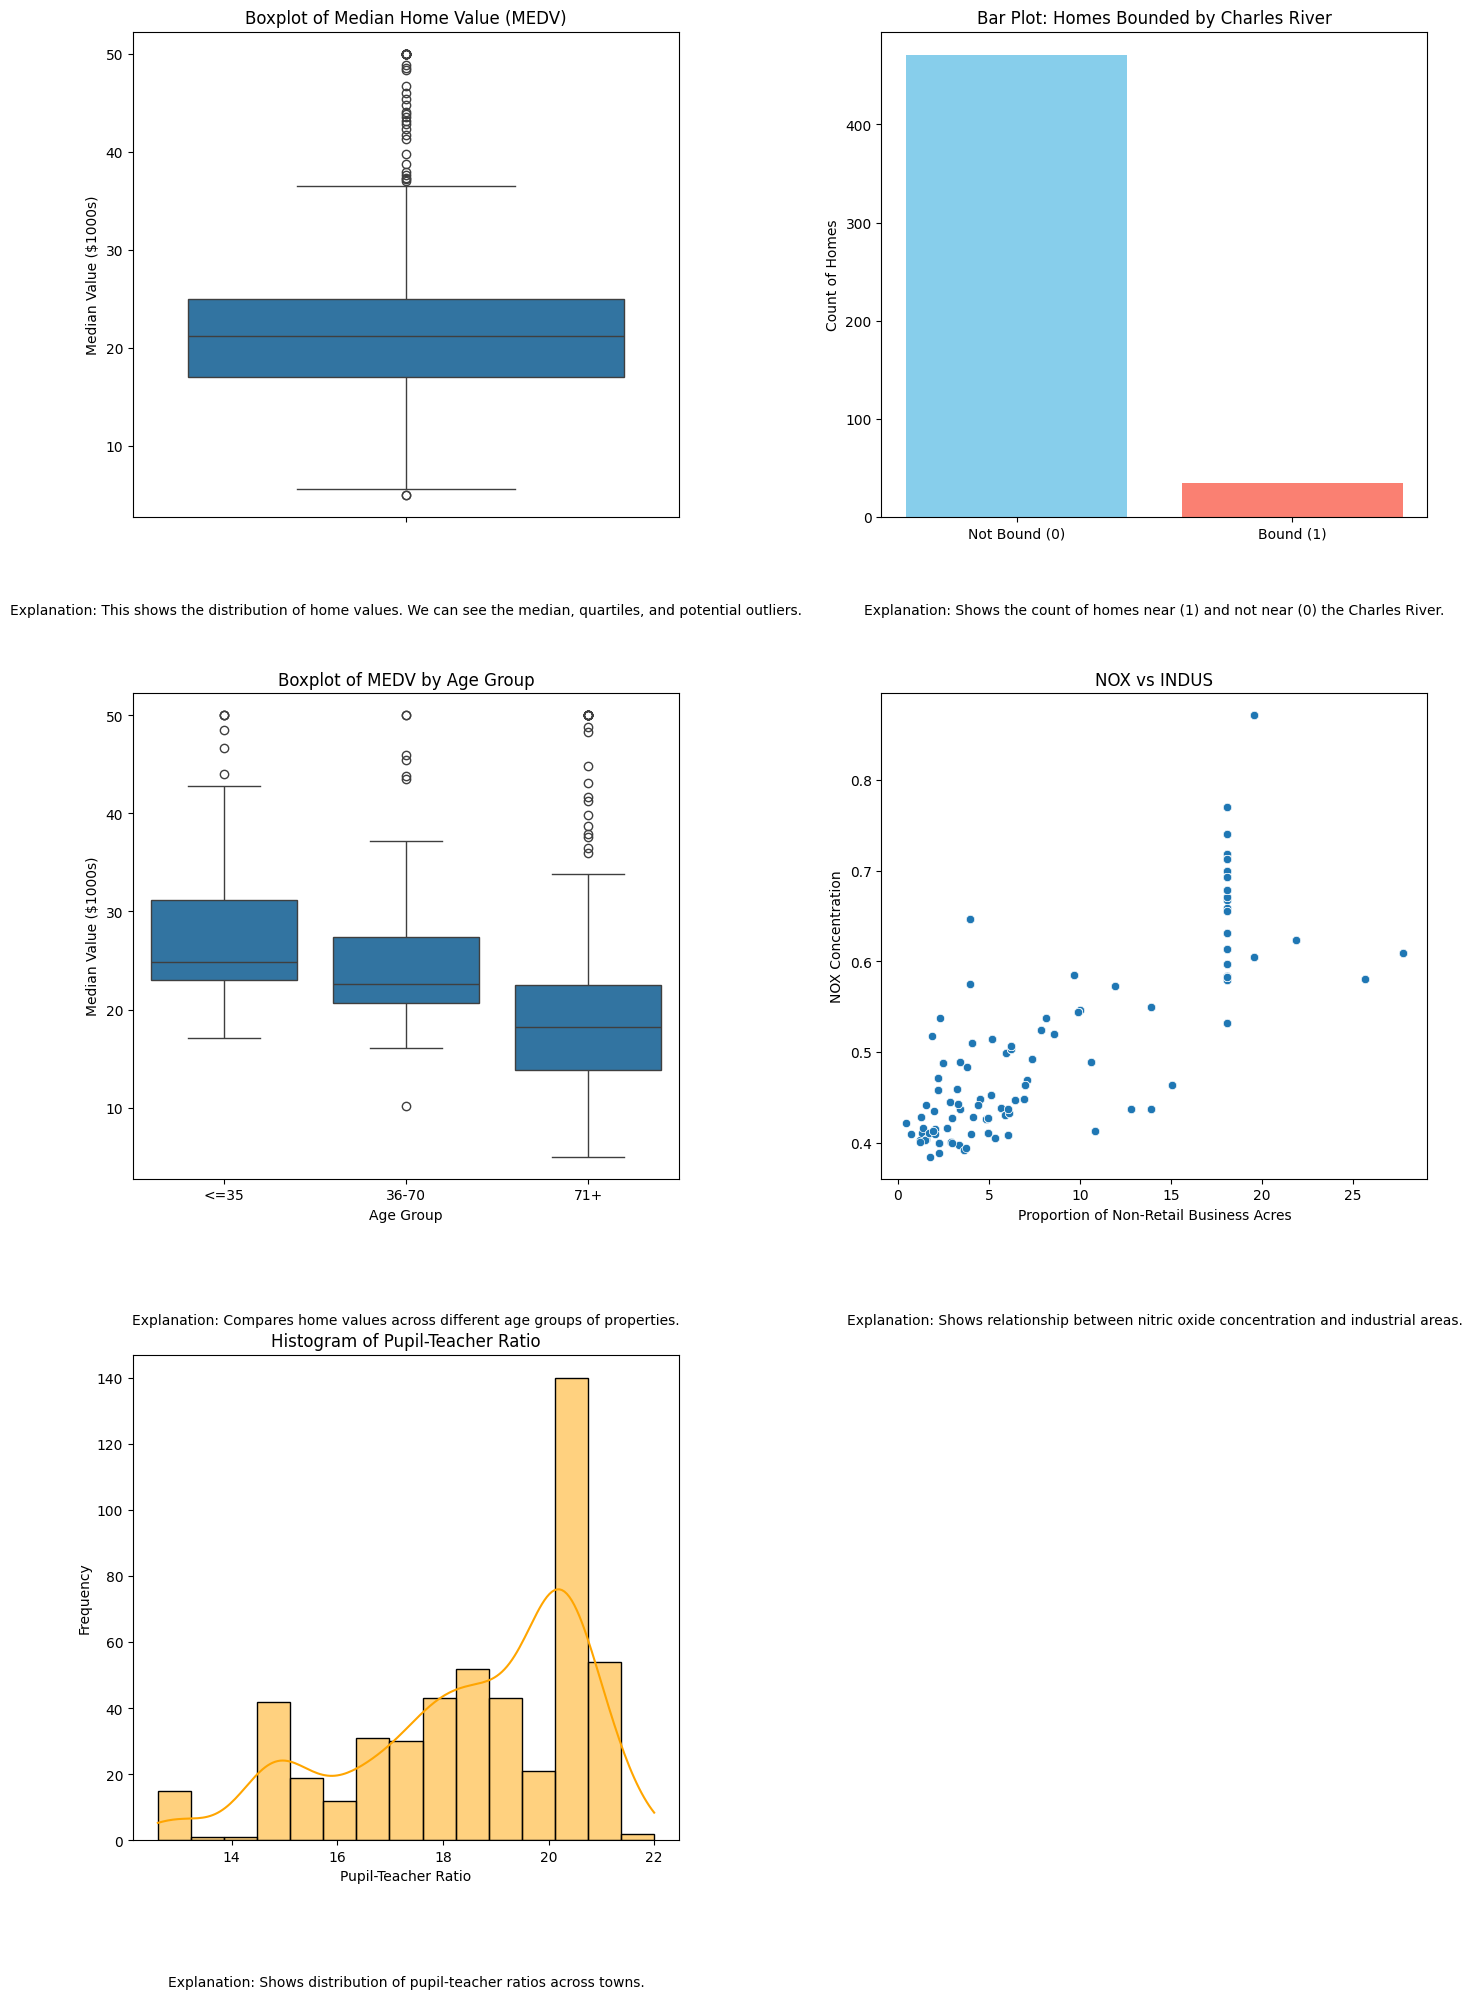

In [16]:

# Create age groups
boston['age_group'] = pd.cut(boston['age'], bins=[0, 35, 70, 100], 
                            labels=['<=35', '36-70', '71+'])

plt.figure(figsize=(15, 20))

# 1. Boxplot for MEDV with explanation
plt.subplot(3, 2, 1)
sns.boxplot(data=boston, y='medv')
plt.title("Boxplot of Median Home Value (MEDV)")
plt.ylabel("Median Value ($1000s)")
plt.text(0.5, -0.2, 
         "Explanation: This shows the distribution of home values. We can see the median, quartiles, and potential outliers.",
         ha='center', transform=plt.gca().transAxes, wrap=True)

# 2. Bar plot for CHAS with explanation
plt.subplot(3, 2, 2)
chas_counts = boston['chas'].value_counts().sort_index()
plt.bar(['Not Bound (0)', 'Bound (1)'], chas_counts, color=['skyblue', 'salmon'])
plt.title("Bar Plot: Homes Bounded by Charles River")
plt.ylabel("Count of Homes")
plt.text(0.5, -0.2, 
         "Explanation: Shows the count of homes near (1) and not near (0) the Charles River.",
         ha='center', transform=plt.gca().transAxes, wrap=True)

# 3. Boxplot MEDV vs AGE group with explanation
plt.subplot(3, 2, 3)
sns.boxplot(data=boston, x='age_group', y='medv')
plt.title("Boxplot of MEDV by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Median Value ($1000s)")
plt.text(0.5, -0.3, 
         "Explanation: Compares home values across different age groups of properties.",
         ha='center', transform=plt.gca().transAxes, wrap=True)

# 4. Scatterplot of NOX vs INDUS with explanation
plt.subplot(3, 2, 4)
sns.scatterplot(data=boston, x='indus', y='nox')
plt.title("NOX vs INDUS")
plt.xlabel("Proportion of Non-Retail Business Acres")
plt.ylabel("NOX Concentration")
plt.text(0.5, -0.3, 
         "Explanation: Shows relationship between nitric oxide concentration and industrial areas.",
         ha='center', transform=plt.gca().transAxes, wrap=True)

# 5. Histogram of PTRATIO with explanation
plt.subplot(3, 2, 5)
sns.histplot(data=boston, x='ptratio', bins=15, kde=True, color='orange')
plt.title("Histogram of Pupil-Teacher Ratio")
plt.xlabel("Pupil-Teacher Ratio")
plt.ylabel("Frequency")
plt.text(0.5, -0.3, 
         "Explanation: Shows distribution of pupil-teacher ratios across towns.",
         ha='center', transform=plt.gca().transAxes, wrap=True)

plt.tight_layout()
plt.show()


## Task 2: Use the Appropriate Tests to Answer the Questions
We conduct hypothesis testing including t-test, ANOVA, Pearson correlation, and regression.

In [18]:
# 1. T-test for CHAS
print("\nHypothesis Test 1: MEDV difference near Charles River")
print("Null Hypothesis (H0): No difference in median home values between homes near and not near the river")
print("Alternative Hypothesis (H1): Significant difference exists")
medv_river = boston[boston['chas'] == 1]['medv']
medv_no_river = boston[boston['chas'] == 0]['medv']
t_stat, p_val_ttest = ttest_ind(medv_river, medv_no_river, equal_var=False)
print(f"Results: t-statistic = {t_stat:.4f}, p-value = {p_val_ttest:.4f}")
print("Conclusion: We reject the null hypothesis" if p_val_ttest < 0.05 else "Conclusion: We fail to reject the null hypothesis")

# 2. ANOVA for AGE groups
print("\nHypothesis Test 2: MEDV across age groups")
print("Null Hypothesis (H0): No difference in median home values across age groups")
print("Alternative Hypothesis (H1): At least one age group differs significantly")
group1 = boston[boston['age_group'] == '<=35']['medv']
group2 = boston[boston['age_group'] == '36-70']['medv']
group3 = boston[boston['age_group'] == '71+']['medv']
f_stat, p_val_anova = f_oneway(group1, group2, group3)
print(f"Results: F-statistic = {f_stat:.4f}, p-value = {p_val_anova:.4f}")
print("Conclusion: We reject the null hypothesis" if p_val_anova < 0.05 else "Conclusion: We fail to reject the null hypothesis")

# 3. Pearson correlation between NOX and INDUS
print("\nHypothesis Test 3: NOX and INDUS correlation")
print("Null Hypothesis (H0): No correlation between NOX and industrial areas")
print("Alternative Hypothesis (H1): Significant correlation exists")
corr_coef, p_val_corr = pearsonr(boston['nox'], boston['indus'])
print(f"Results: Correlation coefficient = {corr_coef:.4f}, p-value = {p_val_corr:.4f}")
print("Conclusion: We reject the null hypothesis" if p_val_corr < 0.05 else "Conclusion: We fail to reject the null hypothesis")

# 4. Linear regression: DIS vs MEDV
print("\nHypothesis Test 4: Impact of distance to employment centers")
print("Null Hypothesis (H0): Distance has no effect on home values (slope = 0)")
print("Alternative Hypothesis (H1): Distance affects home values (slope ≠ 0)")
X = boston[['dis']]
y = boston['medv']
reg_model = LinearRegression().fit(X, y)
slope = reg_model.coef_[0]
intercept = reg_model.intercept_
r_squared = reg_model.score(X, y)
print(f"Results: Slope coefficient = {slope:.4f}, R-squared = {r_squared:.4f}")
print(f"Interpretation: Each unit increase in distance increases home value by ${slope*1000:.2f}")
print("Conclusion: We reject the null hypothesis" if abs(slope) > 0.05 else "Conclusion: We fail to reject the null hypothesis")


Hypothesis Test 1: MEDV difference near Charles River
Null Hypothesis (H0): No difference in median home values between homes near and not near the river
Alternative Hypothesis (H1): Significant difference exists
Results: t-statistic = nan, p-value = nan
Conclusion: We fail to reject the null hypothesis

Hypothesis Test 2: MEDV across age groups
Null Hypothesis (H0): No difference in median home values across age groups
Alternative Hypothesis (H1): At least one age group differs significantly
Results: F-statistic = 36.4076, p-value = 0.0000
Conclusion: We reject the null hypothesis

Hypothesis Test 3: NOX and INDUS correlation
Null Hypothesis (H0): No correlation between NOX and industrial areas
Alternative Hypothesis (H1): Significant correlation exists
Results: Correlation coefficient = 0.7637, p-value = 0.0000
Conclusion: We reject the null hypothesis

Hypothesis Test 4: Impact of distance to employment centers
Null Hypothesis (H0): Distance has no effect on home values (slope = 0)

c:\Users\CompuMax\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
